### Importing Necessary Libraries

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from tensorflow.keras.layers import Conv2D
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from keras.layers import MaxPool2D
from random import shuffle
from glob import glob
import warnings
import os
import re
warnings.filterwarnings('ignore')

### Reading Data

In [24]:
# Reading data from files
train = glob("data/train/*.jpeg")
test = glob("data/test/*.jpeg")

# Randomizing the data
shuffle(train)
shuffle(test)

# Taking only 4000 samples from train & test
train = train[:4000]
test = test[:4000]

# piece symbols to be used in FEN definitions
piece_symbols = 'prbnkqPRBNKQ'

### Exploratory Data Analysis (EDA)

In [25]:
# Function to get the labels from the Images
def fen_from_file(filename):
    base = os.path.basename(filename)
    return os.path.splitext(base)[0]

### LABEL Samples

In [26]:
print("For TRAIN")
print(fen_from_file(train[0]), '\n', fen_from_file(train[1]), '\n', fen_from_file(train[2]))
print("For TEST")
print(fen_from_file(test[0]), '\n', fen_from_file(test[1]), '\n', fen_from_file(test[2]))

For TRAIN
6q1-BR6-2Q1k3-5B2-6N1-3Q4-K3b1b1-2b2N2 
 1rKr4-p2r1p2-8-N2N2r1-4Q1k1-8-6P1-8 
 6b1-6k1-7B-7b-R2K4-8-n7-5bR1
For TEST
1K6-8-8-b3q3-8-8-5P2-2r4k 
 3b4-2q5-8-3b4-1K6-8-1r6-2k3B1 
 4R2B-2B5-4P3-4P3-2P2k2-5q2-4K3-3n4


### Image samples

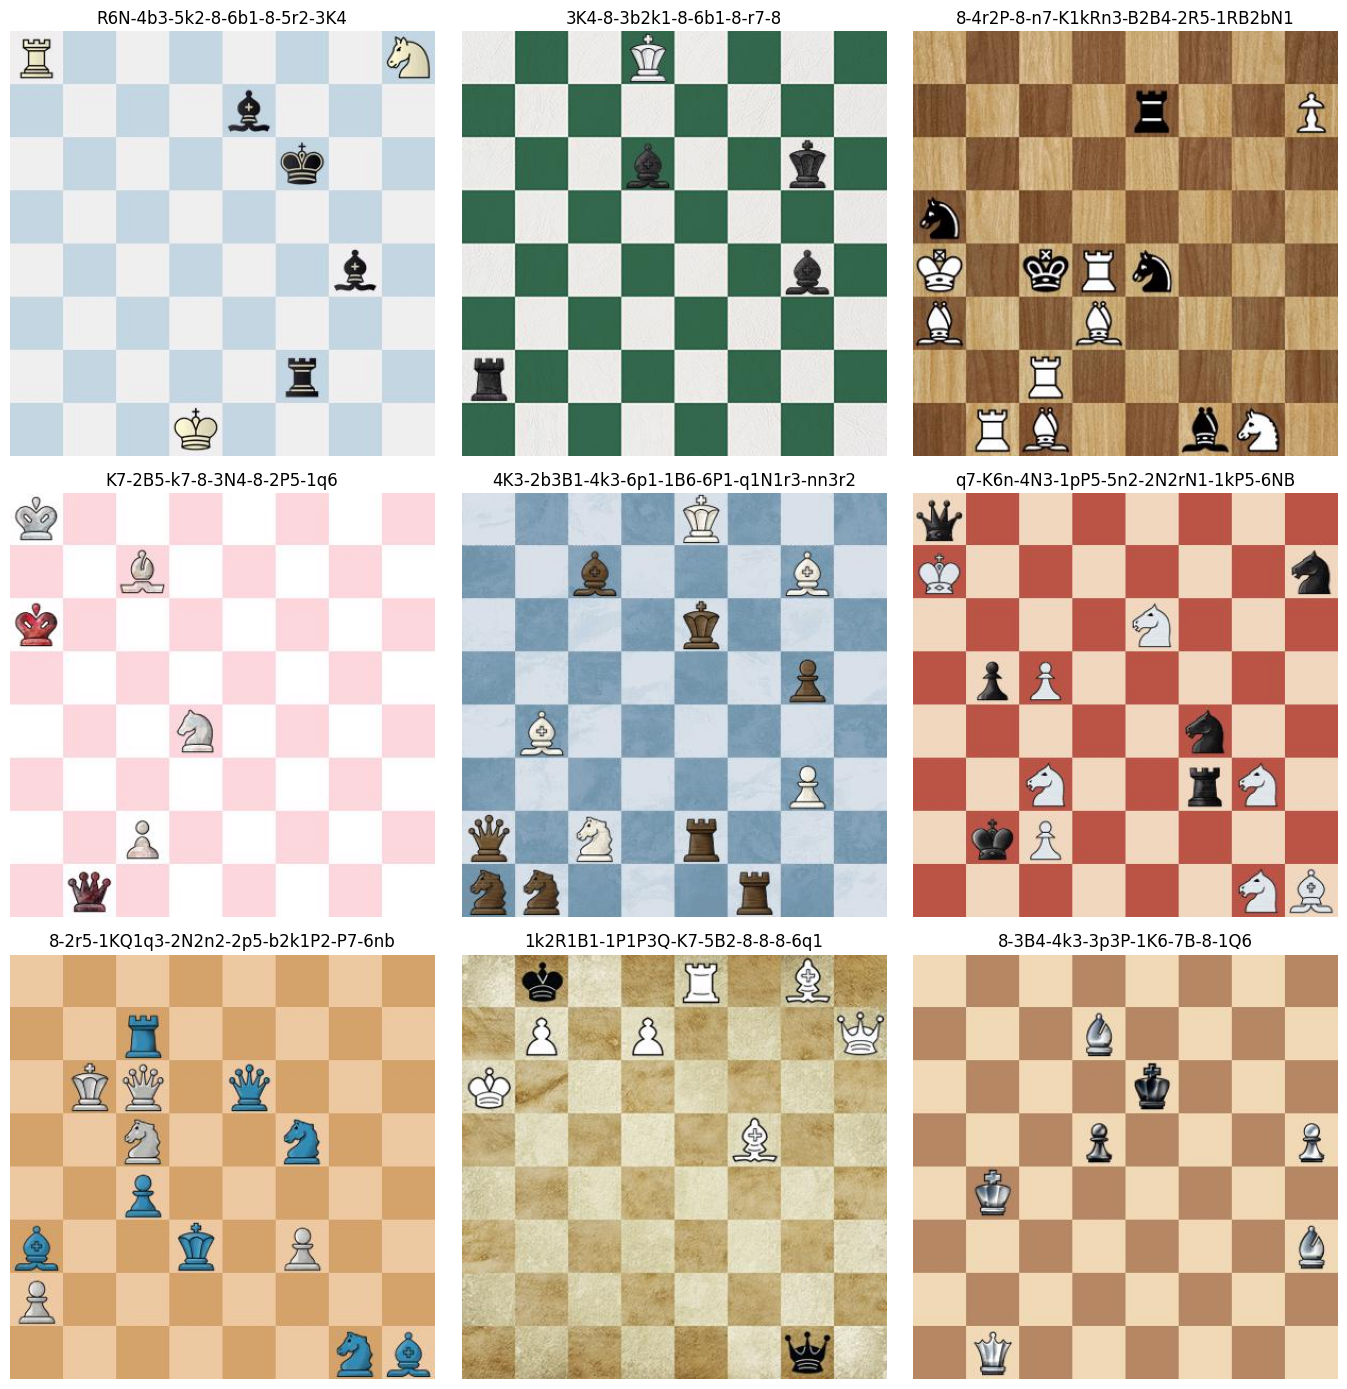

In [27]:
# Taking 9 Image samples from Test Data and Plotting

import random

samples = random.sample(train, 9)
fig = plt.figure(figsize=(14, 14))
columns = 3
rows = 3
for i, img in zip(range(1, columns*rows +1),samples ):
    fig.add_subplot(rows, columns, i)
    img_moves =  fen_from_file(img)
    img = cv2.imread(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(img_moves)
    plt.tight_layout()
    
plt.show()

In [28]:
# Viewing the samples in Text
samples

['data/train/R6N-4b3-5k2-8-6b1-8-5r2-3K4.jpeg',
 'data/train/3K4-8-3b2k1-8-6b1-8-r7-8.jpeg',
 'data/train/8-4r2P-8-n7-K1kRn3-B2B4-2R5-1RB2bN1.jpeg',
 'data/train/K7-2B5-k7-8-3N4-8-2P5-1q6.jpeg',
 'data/train/4K3-2b3B1-4k3-6p1-1B6-6P1-q1N1r3-nn3r2.jpeg',
 'data/train/q7-K6n-4N3-1pP5-5n2-2N2rN1-1kP5-6NB.jpeg',
 'data/train/8-2r5-1KQ1q3-2N2n2-2p5-b2k1P2-P7-6nb.jpeg',
 'data/train/1k2R1B1-1P1P3Q-K7-5B2-8-8-8-6q1.jpeg',
 'data/train/8-3B4-4k3-3p3P-1K6-7B-8-1Q6.jpeg']

## Data Preprocessing

In [29]:
# The function to change the training images into array
def images_to_array(images_path, height, width):
    image_list = []

    for the_path in images_path:
        image = cv2.imread(the_path)
        image = cv2.resize(image , (height, width))
        image_list.append([np.array(image)])
    
    shuffle(image_list)
    array_image = np.array(image_list)
    images = array_image[:,0,:,:]
    return(images)

In [30]:
# Preprocessing the Images
preprocessed_imgs= images_to_array(samples,240,240)

In [31]:
# Checking to see the size of the preprocessed Images
"{}X{}".format(preprocessed_imgs[0].shape[0],preprocessed_imgs[0].shape[1])

'240X240'

In [32]:
# Checking to see the shape of the Preprocessed Image
preprocessed_imgs[0].shape

(240, 240, 3)

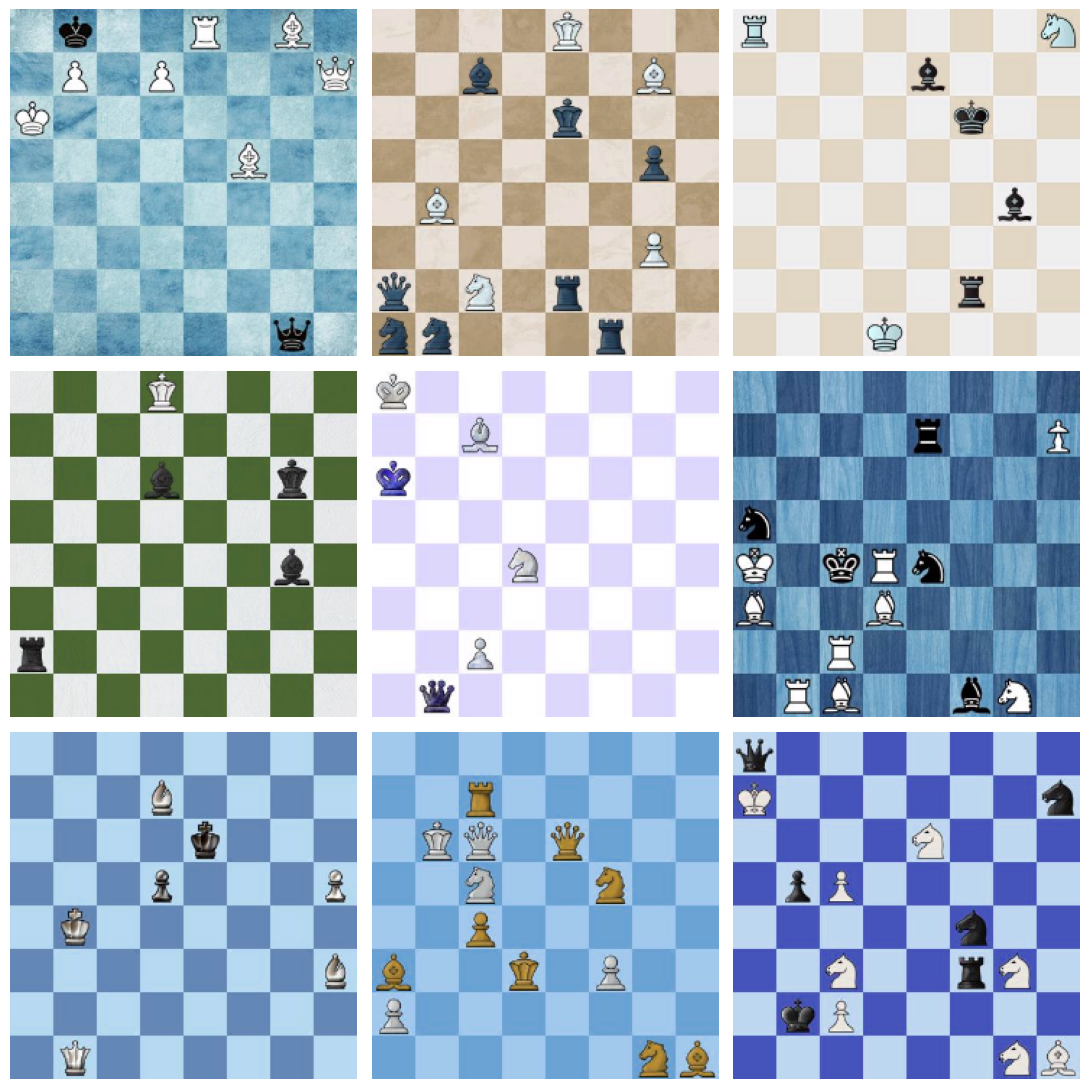

In [33]:
# Showing the Preprocessed Images

fig = plt.figure(figsize=(11, 11))
columns = 3
rows = 3
for i, img in zip(range(1, columns*rows +1), preprocessed_imgs):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()

## Data Encoding to Use in Training

In [34]:
def onehot_from_fen(fen):
    eye = np.eye(NB_CLASSES)
    output = np.empty((0, NB_CLASSES))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, NB_CLASSES)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))
    return output

#### Proccess images

In [35]:
def process_image(img):
    downsample_size = 200
    square_size = int(downsample_size/8)
    img_read = io.imread(img)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)

    return tiles.reshape(64, square_size, square_size, 3)

### Functions for sampling batches for training and evaluation

In [36]:
def train_gen(features):
    for _, img in enumerate(features):
        y = onehot_from_fen(fen_from_file(img))
        x = process_image(img)
        yield x, y

def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_image(img)

### Define the model

In [37]:
# Set training parameters
img_rows = 25
img_cols = 25
EPOCHS = 10
BATCH_SIZE = 8
NB_CLASSES = 13

### Building a Convolutional Neural Network

In [38]:
model = Sequential()
model.add(Conv2D(15, kernel_size=2, activation='relu', 
          input_shape=(img_rows, img_cols, 3)))
model.add(MaxPool2D(2))
model.add(Conv2D(5, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(13, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 15)        195       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 15)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 5)         305       
                                                                 
 flatten_1 (Flatten)         (None, 605)               0         
                                                                 
 dropout_1 (Dropout)         (None, 605)               0         
                                                                 
 dense_1 (Dense)             (None, 13)                7878      
                                                      

### Compiling the Model

In [39]:
# Compile the model 
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Training the model

In [40]:
# Fit params
history = model.fit_generator(
    train_gen(train), steps_per_epoch=len(train)//EPOCHS,
    epochs=EPOCHS, verbose=1, validation_data=train_gen(test),
    validation_steps=len(test)//EPOCHS
)

Epoch 1/10


400/400 [==============================] - 15s 36ms/step - loss: 0.6661 - accuracy: 0.8577 - val_loss: 0.2424 - val_accuracy: 0.9532
Epoch 2/10
400/400 [==============================] - 14s 35ms/step - loss: 0.1852 - accuracy: 0.9538 - val_loss: 0.1021 - val_accuracy: 0.9772
Epoch 3/10
400/400 [==============================] - 14s 34ms/step - loss: 0.1037 - accuracy: 0.9736 - val_loss: 0.0640 - val_accuracy: 0.9841
Epoch 4/10
400/400 [==============================] - 14s 34ms/step - loss: 0.0683 - accuracy: 0.9817 - val_loss: 0.0602 - val_accuracy: 0.9838
Epoch 5/10
400/400 [==============================] - 13s 34ms/step - loss: 0.0542 - accuracy: 0.9848 - val_loss: 0.0316 - val_accuracy: 0.9915
Epoch 6/10
400/400 [==============================] - 13s 34ms/step - loss: 0.0455 - accuracy: 0.9873 - val_loss: 0.0226 - val_accuracy: 0.9947
Epoch 7/10
400/400 [==============================] - 13s 32ms/step - loss: 0.0399 - accuracy: 0.9887 - val_loss: 0.0215 - val_accuracy: 0.9953
Epo

### Performance Evaluation

In [41]:
res = (
    model.predict_generator(pred_gen(test, 64))
    .argmax(axis=1)
    .reshape(-1, 8, 8)
)

In [42]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([fen_from_file(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Accuracy: {:2f}".format(final_accuracy))

Accuracy: 0.945750


In [43]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Plotting the Evaluation and Losses

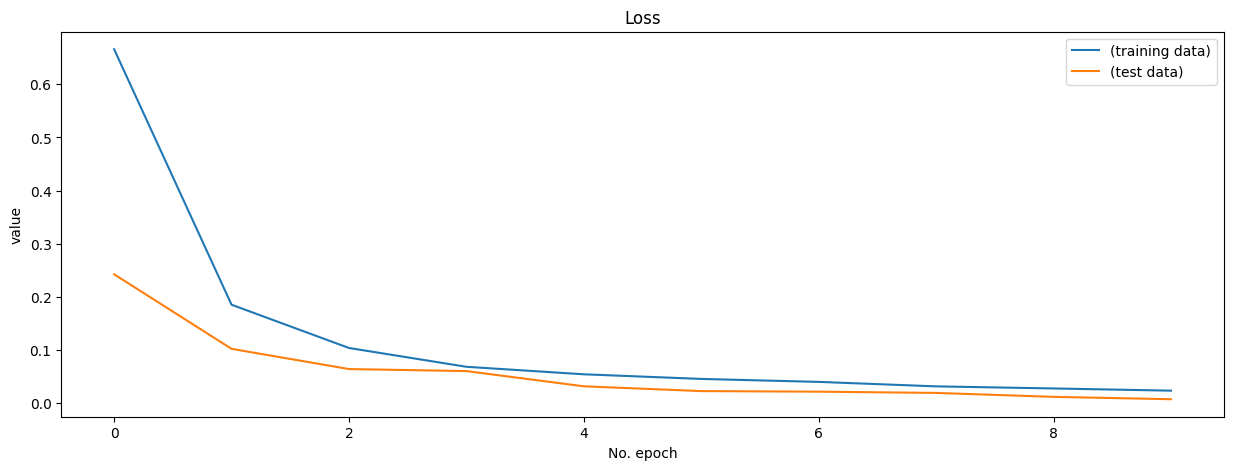

In [44]:
fig = plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='(training data)')
plt.plot(history.history['val_loss'], label='(test data)')

plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.title('Loss')
plt.show()

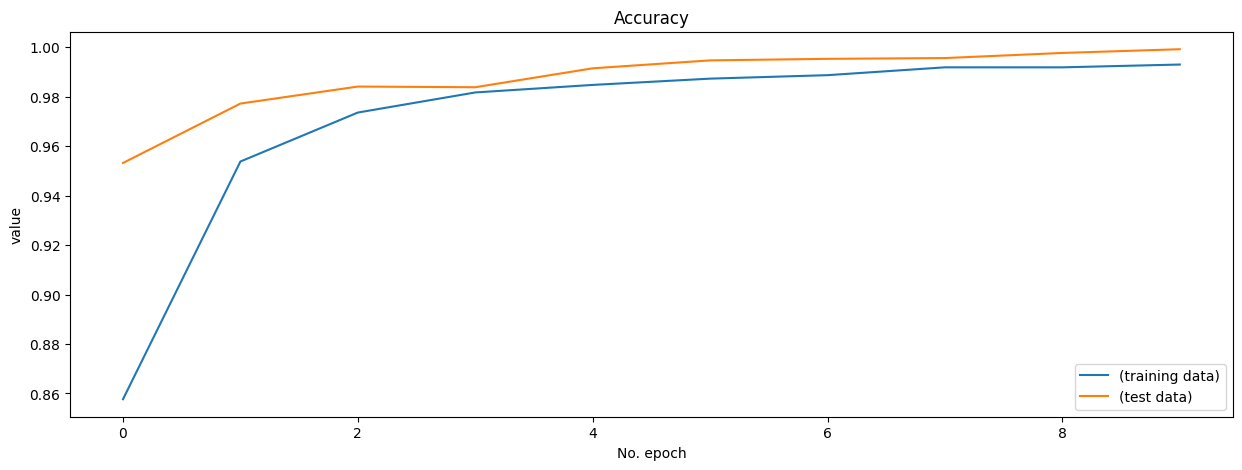

In [45]:
fig = plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'], label='(training data)')
plt.plot(history.history['val_accuracy'], label='(test data)')

plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.title('Accuracy')
plt.show()

### Confusion Matrix

In [46]:
from sklearn.metrics import confusion_matrix,f1_score
print("\nConfusion Matrix:\n------------------------")
confusion_matrix(test_fens, pred_fens)


Confusion Matrix:
------------------------


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

### Sample Predictions

In [47]:
def predicted_fen_plot(image):
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()

2/2 [==============================] - 0s 4ms/step


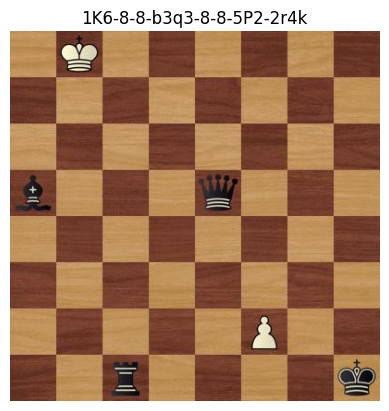

2/2 [==============================] - 0s 3ms/step


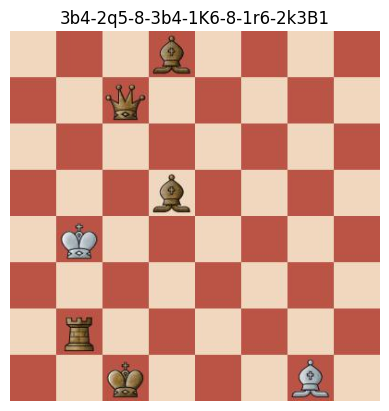

2/2 [==============================] - 0s 4ms/step


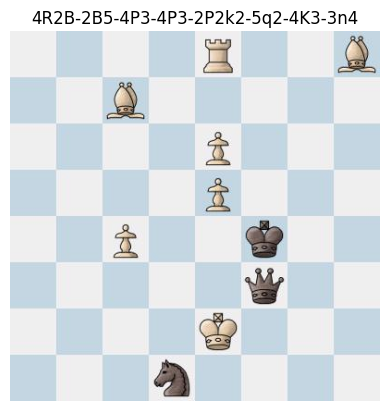

None None None


In [48]:
print(predicted_fen_plot(test[0]), predicted_fen_plot(test[1]), predicted_fen_plot(test[2]))